# Data Preparation

In [1]:
from numpy import asarray
from numpy import save
from predictor.driver import Predictor
from predictor.src import utils
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training_data, names_list, scores_list = utils.load_training_data()
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])

X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))

non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]

(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=5)

scores_filtered = [scores_list[i] for i in indices_test]

# scaler = preprocessing.StandardScaler().fit(X_train)
# in_max_scaler = preprocessing.MinMaxScaler()

# X_train = preprocessing.normalize(X_train, norm='l2')

# m = np.mean(X_train, axis=0) # array([16.25, 26.25])
# std = np.std(X_train, axis=0) # array([17.45530005, 22.18529919])

# X_train = 0.5 * (np.tanh(0.01 * ((X_train - m) / std)) + 1)

predictor = Predictor()
performance=[]

# Current Decision Tree Classifier

In [2]:
#predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


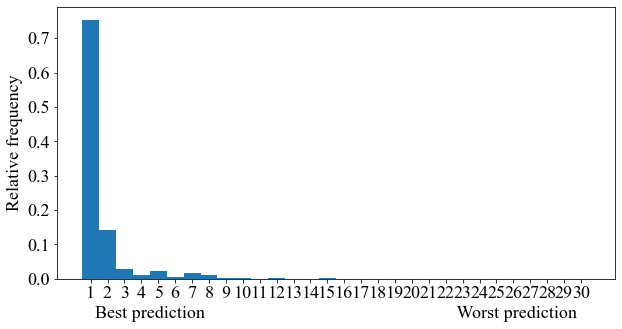

Best Accuracy:  0.7524685213756035
Top 3:  0.9243421052631579
Feature Importance:  [0.021893   0.         0.         0.03567263 0.         0.
 0.         0.04952939 0.         0.         0.         0.
 0.         0.         0.         0.         0.00481344 0.
 0.         0.         0.33377769 0.13789793 0.04844336 0.128165
 0.10049397 0.10130024 0.03801337]


In [3]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

clf = tree.DecisionTreeClassifier(random_state=5)

tree_param = [
    {
        "criterion": ["entropy", "gini"],
        "max_depth": list(range(1, 15, 1)),
        "min_samples_split": list(range(2, 20, 4)),
        "min_samples_leaf": list(range(2, 20, 4)),
        "max_leaf_nodes": list(range(2, 200, 40)),
        "max_features": list(range(1, len(non_zero_indices), 10)),
    },
]
clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)
y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test, filename="DecisionTreeClassifier")

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("DecisionTreeClassifier", clf.best_score_, top3, max(res)))

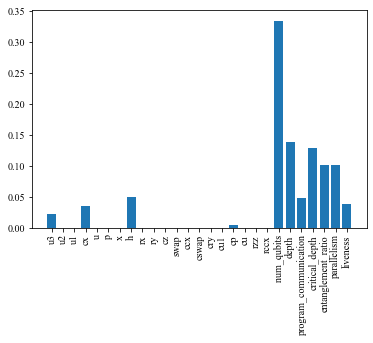

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

openqasm_qc_list = utils.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
feature_names.append("num_qubits")
feature_names.append("depth")
feature_names.append("program_communication")
feature_names.append("critical_depth")
feature_names.append("entanglement_ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

plt.bar(feature_names, clf.best_estimator_.feature_importances_)
plt.xticks(rotation=90)
plt.show()

# Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=0)

tree_param = [
    {
        "n_estimators": [100,200,500],
        "max_features": ["auto", "sqrt"],
        "max_depth": list(range(8, 30, 6)),
        "min_samples_split": list(range(2, 20, 6)),
        "min_samples_leaf": list(range(2, 20, 6)),
        "bootstrap": [True, False],
    },
]

clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)


y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test, filename="RandomForestClassifier")

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("RandomForestClassifier", clf.best_score_, top3, max(res)))

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

### Feature Importances

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

openqasm_qc_list = utils.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
feature_names.append("num_qubits")
feature_names.append("depth")
feature_names.append("program_communication")
feature_names.append("critical_depth")
feature_names.append("entanglement_ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

importances = clf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.best_estimator_.estimators_], axis=0)

plt.figure(figsize=(15,10))
plt.bar(feature_names, importances)
plt.errorbar(feature_names, importances, std, fmt="o", color="r")
plt.xticks(rotation=90)
plt.title("Feature Importance based on mean decrease in impurity")
plt.xlabel("Feature")
plt.xlabel("Importance")
plt.show()
plt.savefig("feature_importances.pdf")

# Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 10, 1))
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test, filename="KNeighborsClassifier")

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print(("Top 3: ", top3))
performance.append(("KNeighborsClassifier", clf.best_score_, top3, max(res)))

# SVM

In [ ]:
from sklearn import svm

clf = svm.SVC()
param_grid = {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01], "kernel": ["rbf", "sigmoid"]}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test, filename="SVM")

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("SVM", clf.best_score_, top3, max(res)))

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test, filename="SVM")

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("Naive Bayes", clf.best_score_, top3, max(res)))

# SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)

param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("SGDClassifier", clf.best_score_, top3, max(res)))

# GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

param_grid = {
    "learning_rate": [0.01, 0.1, 1],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("GradientBoostingClassifier", clf.best_score_, top3, max(res)))

# Save Performance Results

In [ ]:
print(performance)

filename = 'performances.csv'
with open(filename, 'w') as f:
    f.write("ML Algorithm, Accuracy, Top3, Worst Rank\n")
    for sublist in performance:
        line = "{}, {}, {}, {} \n".format(sublist[0], sublist[1], sublist[2], sublist[3])
        f.write(line)

# Debugging